### Цель проекта

Разработать сервис, определяющий, правильно ли сориентирована медицинская справка, загруженная пользователем в сервис для доноров DonorSearch.

Заказчик - DonorSearch -  занимается развитием донорства в стране. Для этого есть платформа DonorSearch.org - где для доноров доступны бонусная программа, игрофикация пути донора и многое другое. Важной является проверка честности доноров и корректности внесенных донаций. Подтверждение производится по справке установленной формы (№405), такую справку донор получает в центре крови.  Далее загружает как картинку или pdf в личный кабинет. 

#### Импорт библиотек

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import warnings
warnings.filterwarnings("ignore")
import os #
import zipfile
import pytesseract
import torch #
import torchvision
from torchvision import datasets, transforms, models #
from torch.utils.data import Dataset,DataLoader, ConcatDataset #
from torchvision import datasets, transforms
from torchvision.transforms import v2 as T
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.nn as nn #
import torch.nn.functional as F
import torch.optim as optim #
from torch.optim import lr_scheduler
from time import time
from tqdm import tqdm
from PIL import Image #
from skimage.io import imread
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)
import cv2
import matplotlib.pyplot as plt #
import seaborn as sns #
import random
import shutil
from sklearn.preprocessing import label_binarize
from torchvision.models import resnet50, ResNet50_Weights, densenet121, DenseNet121_Weights,resnet18, ResNet18_Weights, vgg19
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay #

/kaggle/input/labels-image/labels_image.csv
/kaggle/input/more-images/more_images/405___b6c1b16eaa1240a3a5fdb9d272133404_rotated_90.png
/kaggle/input/more-images/more_images/405___photo_2023-03-17_16-43-55_original.png
/kaggle/input/more-images/more_images/405___701b3c25428b4f6c8d71396037202683_rotated_90.png
/kaggle/input/more-images/more_images/405___b7a58da969de42ecb64c589d3ecd7642_original.png
/kaggle/input/more-images/more_images/405___83a46dc4d8554fecae624a5422028422_rotated_180.png
/kaggle/input/more-images/more_images/405___d810c46007b741759c70f34a857445eb_rotated_270.png
/kaggle/input/more-images/more_images/405___82094d1fddd946c3a7fdeff1f22b06fe_rotated_180.png
/kaggle/input/more-images/more_images/405___87bdaaa7ba5247c1969398f16a341917_rotated_90.png
/kaggle/input/more-images/more_images/405___049481224374486ead31511817c052f3_rotated_180.png
/kaggle/input/more-images/more_images/405___f72dc98db3df421f904e571318ce94f8_rotated_270.png
/kaggle/input/more-images/more_images/405_

#### Загрузка данных

In [13]:
# Загрузка данных из CSV
df = pd.read_csv('/kaggle/input/labels-image/labels_image.csv')  #путь к файлу

# Предположим, что CSV имеет колонки 'image_path' и 'category'
# Создаем основную папку для категорий
base_dir = 'images_category'
os.makedirs(base_dir, exist_ok=True)

# Получаем уникальные категории
categories = df['category'].unique()

# Создаем папки для каждой категории
for category in categories:
    category_path = os.path.join(base_dir, category)
    os.makedirs(category_path, exist_ok=True)

# Перемещаем изображения в соответствующие папки
for index, row in df.iterrows():
    image_path = row['label']
    category = row['category']
    
    # Проверьте, существует ли изображение
    if os.path.isfile(image_path):
        # Перемещаем изображение в соответствующую папку
        shutil.copy(image_path, os.path.join(base_dir, category, os.path.basename(image_path)))
    else:
        print(f'Image not found: {image_path}')

In [14]:
# Создаем папку
output_dir = '/kaggle/working/result'
os.makedirs(output_dir, exist_ok=True)

In [15]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [16]:
# Параметры
DATA_DIR = '/kaggle/working/images_category'# Папка с изображениями
OUT_DIR = '/kaggle/working/result'
FOLDERS = ['original', '90', '180', '270']
CLASSES = {'original': 0, 
           '90': 1, 
           '180': 2,
           '270': 3    
}

In [17]:
BATCH_SIZE = 16
GENERATOR = torch.Generator().manual_seed(1001)

#### Трансформации

In [18]:
# Трансформации для изображений
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

#### Датасеты и выборки

In [19]:
class Page(torch.utils.data.Dataset):
    def __init__(self, root, label, transform):
        self.root = root
        self.label = label
        self.transforms = transform
        self.imgs = os.listdir(os.path.join(self.root, self.label))

    def __getitem__(self, idx):
        # load images and labels
        img_path = os.path.join(self.root, self.label, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        target = CLASSES[self.label]

        return self.transforms(img), torch.tensor(target), self.label

    def __len__(self):
        return len(self.imgs)

In [20]:
data_1 = Page(DATA_DIR, FOLDERS[0], transform)
data_2 = Page(DATA_DIR, FOLDERS[1], transform)
data_3 = Page(DATA_DIR, FOLDERS[2], transform)
data_4 = Page(DATA_DIR, FOLDERS[3], transform)
print(f'Размер категории: \n {FOLDERS[0]} - {len(data_1)} \n {FOLDERS[1]} - {len(data_2)} \n {FOLDERS[2]} - {len(data_3)} \n {FOLDERS[3]} - {len(data_4)} \n')
data_page = ConcatDataset([data_1, data_2, data_3, data_4])
train, valid, test = torch.utils.data.random_split(data_page, [.6, .2, .2], generator=GENERATOR)
print(f'Размер выборок: \nтренировочная - {len(train)} \nвалидационная - {len(valid)} \nтестовая - {len(test)}')

Размер категории: 
 original - 48 
 90 - 48 
 180 - 48 
 270 - 48 

Размер выборок: 
тренировочная - 116 
валидационная - 38 
тестовая - 38


In [21]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

#### Обзор

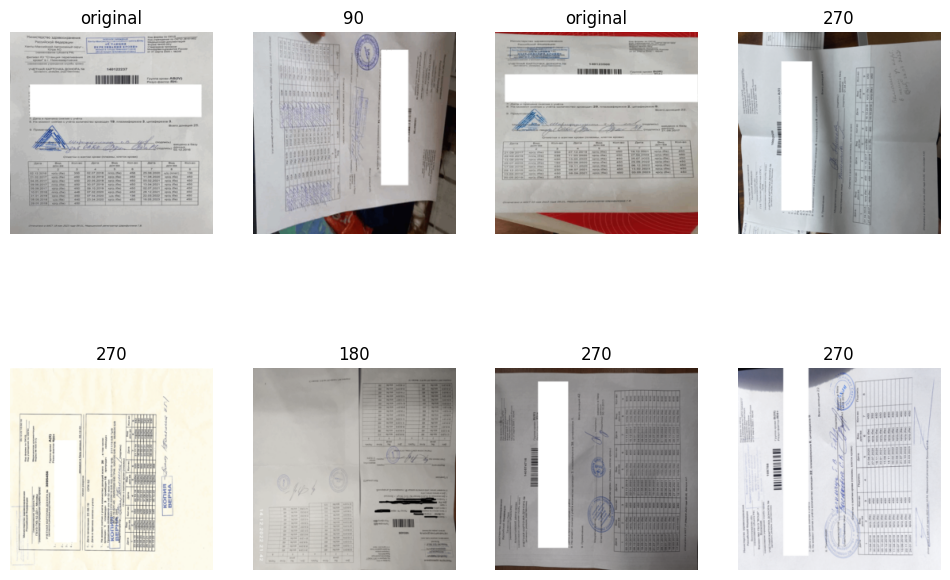

In [22]:
look = next(iter(train_dataloader))
plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis("off")
    plt.imshow(look[0][i].permute(1,2,0))
    plt.title(look[2
                  ][i])
plt.show();

#### Функции обучения, оценки и визуализации

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels, _ in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    scheduler.step()
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels, _ in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [25]:
def predict(model, test_loader):
    running_corrects = 0
    processed_size = 0
    with torch.no_grad():
        logits = []
        preds = []
        answers = []

        for inputs, labels, _ in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(inputs)
            logits.append(outputs.cpu())
            preds.append(torch.argmax(outputs, 1).cpu())
            answers.append(labels.cpu())
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
            processed_size += inputs.size(0)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    preds = torch.cat(preds, dim=-1).numpy()
    answers = torch.cat(answers, dim=-1).numpy()
    test_acc = running_corrects.cpu().numpy() / processed_size
    return answers, preds, probs, test_acc

In [26]:
def vizualize(h, model):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(model)
    plt.show()
    plt.plot(acc, label="train_accuracy")
    plt.plot(val_acc, label="validation_accuracy")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.title(model)
    plt.show()

In [27]:
def train(train, val, model, epochs, rate, criterion):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=rate)
        sch = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train, criterion, opt, sch)

            val_loss, val_acc = eval_epoch(model, val, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

#### Предобученные модели

##### ResNet50

In [28]:
weights = ResNet50_Weights.DEFAULT
resnet = resnet50(weights=weights)

# Set requires_grad = False for all parameters
for param in resnet.parameters():
    param.requires_grad = False

# Re-enable requires_grad for the last 3 layers
layers = list(resnet.children())
for layer in layers[-4:]:
    for param in layer.parameters():
        param.requires_grad = True
in_features = 2048
out_features = 4
resnet.fc = nn.Linear(in_features, out_features)
resnet = resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s] 


In [29]:
out = resnet(torch.rand(64, 3, 224, 224).to(device))

In [30]:
out[0]

tensor([-0.0150,  0.0249, -0.1637,  0.1494], grad_fn=<SelectBackward0>)

##### Mobilenet V2

In [31]:
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet.classifier = nn.Sequential(nn.Dropout(p=0.2, inplace=False),
                  nn.Linear(in_features=mobilenet.classifier[1].in_features, out_features=4, bias=True))
mobilenet = mobilenet.to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 83.6MB/s]


##### DenseNet121

In [32]:
weights = DenseNet121_Weights.DEFAULT
dnet = densenet121(weights=weights)

in_features = 1024
out_features = 4
dnet.classifier = nn.Linear(in_features, out_features)
dnet = dnet.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 113MB/s] 


##### VGG19

In [33]:
vgg = models.vgg19(pretrained=True)
for param in vgg.parameters():
    param.requires_grad = False
    
in_features = 4096
out_features = 4    
vgg.classifier[6] = nn.Linear(in_features, out_features)
vgg = vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 163MB/s]  


#### Обучение

In [34]:
crit = nn.CrossEntropyLoss()
lr = 0.001

In [35]:
history = train(train_dataloader, valid_dataloader, model=resnet, epochs=10, rate=lr, criterion=crit)

epoch:  10%|█         | 1/10 [00:46<06:58, 46.45s/it]


Epoch 001 train_loss: 1.1818     val_loss 0.9503 train_acc 0.5431 val_acc 0.8158


epoch:  20%|██        | 2/10 [01:31<06:06, 45.85s/it]


Epoch 002 train_loss: 0.3963     val_loss 1.3613 train_acc 0.8966 val_acc 0.7632


epoch:  30%|███       | 3/10 [02:16<05:18, 45.44s/it]


Epoch 003 train_loss: 0.3034     val_loss 2.6708 train_acc 0.9310 val_acc 0.8158


epoch:  40%|████      | 4/10 [03:02<04:32, 45.35s/it]


Epoch 004 train_loss: 0.1415     val_loss 3.4944 train_acc 0.9310 val_acc 0.7632


epoch:  50%|█████     | 5/10 [03:45<03:44, 44.84s/it]


Epoch 005 train_loss: 0.1588     val_loss 3.3946 train_acc 0.9655 val_acc 0.7632


epoch:  60%|██████    | 6/10 [04:31<02:59, 44.93s/it]


Epoch 006 train_loss: 0.0534     val_loss 2.2030 train_acc 0.9914 val_acc 0.7632


epoch:  70%|███████   | 7/10 [05:15<02:13, 44.60s/it]


Epoch 007 train_loss: 0.1152     val_loss 1.7202 train_acc 0.9741 val_acc 0.8158


epoch:  80%|████████  | 8/10 [05:58<01:28, 44.23s/it]


Epoch 008 train_loss: 0.0561     val_loss 1.6160 train_acc 0.9914 val_acc 0.7895


epoch:  90%|█████████ | 9/10 [06:41<00:43, 44.00s/it]


Epoch 009 train_loss: 0.0332     val_loss 1.4481 train_acc 1.0000 val_acc 0.7632


epoch: 100%|██████████| 10/10 [07:26<00:00, 44.61s/it]


Epoch 010 train_loss: 0.0422     val_loss 1.4358 train_acc 1.0000 val_acc 0.7895


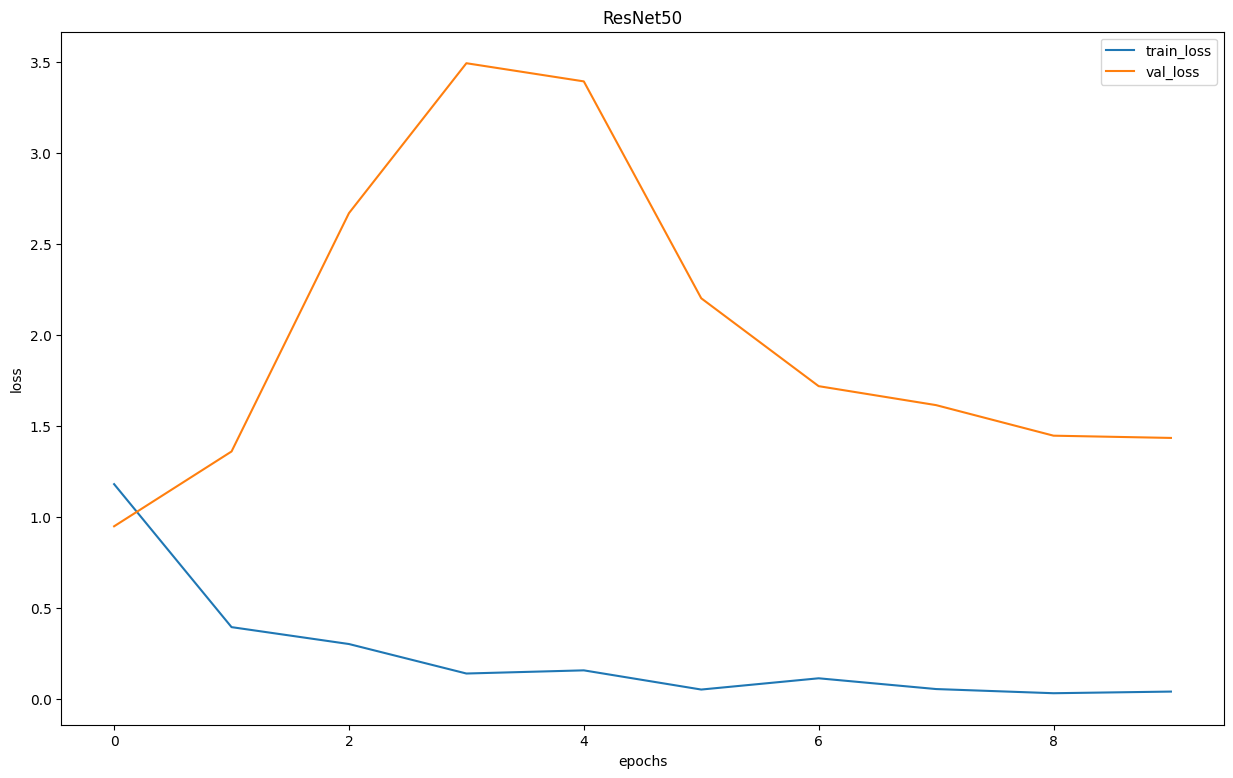

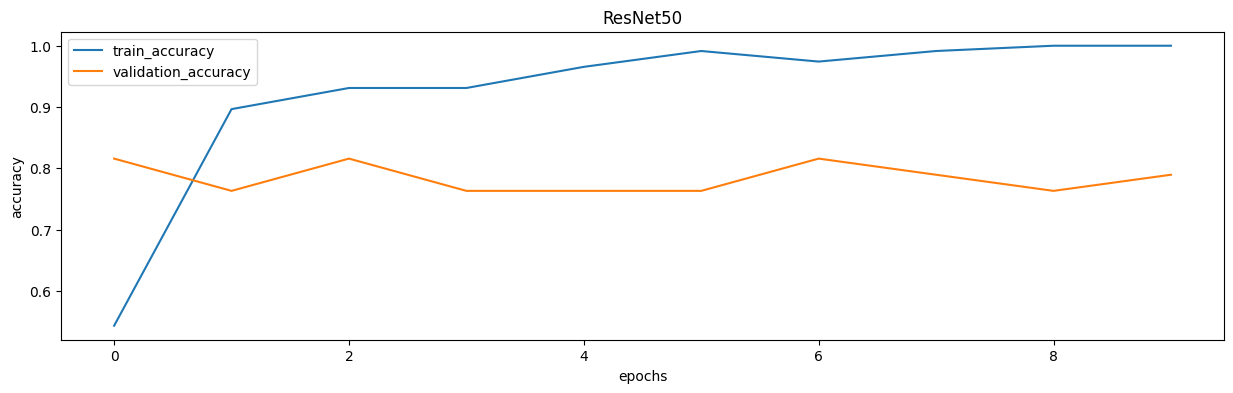

In [36]:
vizualize(history, 'ResNet50')

In [37]:
history_1 = train(train_dataloader, valid_dataloader, model=mobilenet, epochs=10, rate=lr, criterion=crit)

epoch:  10%|█         | 1/10 [00:23<03:32, 23.61s/it]


Epoch 001 train_loss: 1.0477     val_loss 3.0807 train_acc 0.6121 val_acc 0.2368


epoch:  20%|██        | 2/10 [00:43<02:51, 21.39s/it]


Epoch 002 train_loss: 0.4748     val_loss 2.8719 train_acc 0.8103 val_acc 0.4474


epoch:  30%|███       | 3/10 [01:03<02:26, 20.98s/it]


Epoch 003 train_loss: 0.2378     val_loss 1.4027 train_acc 0.8966 val_acc 0.6316


epoch:  40%|████      | 4/10 [01:23<02:03, 20.57s/it]


Epoch 004 train_loss: 0.2958     val_loss 2.0986 train_acc 0.9052 val_acc 0.5789


epoch:  50%|█████     | 5/10 [01:43<01:41, 20.30s/it]


Epoch 005 train_loss: 0.1605     val_loss 1.9888 train_acc 0.9483 val_acc 0.7632


epoch:  60%|██████    | 6/10 [02:02<01:19, 19.95s/it]


Epoch 006 train_loss: 0.1406     val_loss 1.5990 train_acc 0.9569 val_acc 0.7895


epoch:  70%|███████   | 7/10 [02:23<01:00, 20.19s/it]


Epoch 007 train_loss: 0.0796     val_loss 1.3773 train_acc 0.9655 val_acc 0.7895


epoch:  80%|████████  | 8/10 [02:45<00:41, 20.70s/it]


Epoch 008 train_loss: 0.1362     val_loss 1.3248 train_acc 0.9483 val_acc 0.7895


epoch:  90%|█████████ | 9/10 [03:05<00:20, 20.51s/it]


Epoch 009 train_loss: 0.0446     val_loss 1.2063 train_acc 0.9828 val_acc 0.8158


epoch: 100%|██████████| 10/10 [03:25<00:00, 20.56s/it]


Epoch 010 train_loss: 0.0741     val_loss 1.2226 train_acc 0.9828 val_acc 0.8421


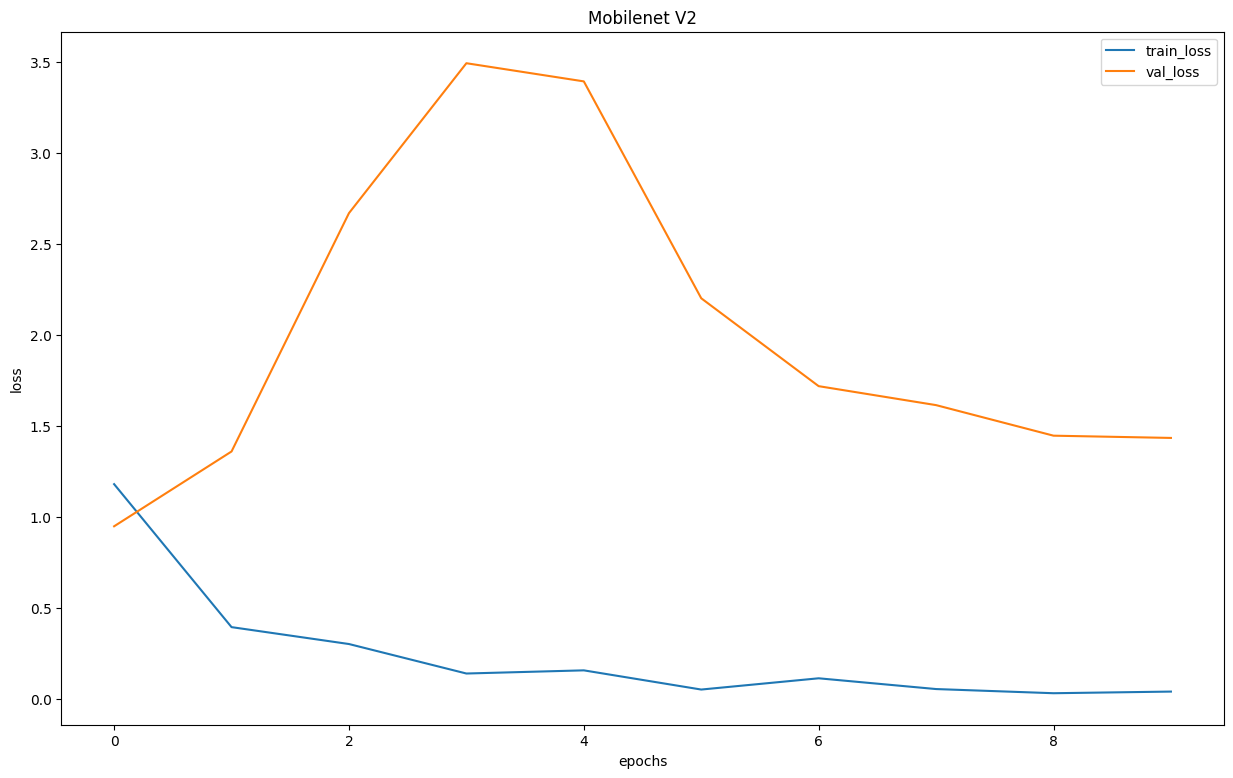

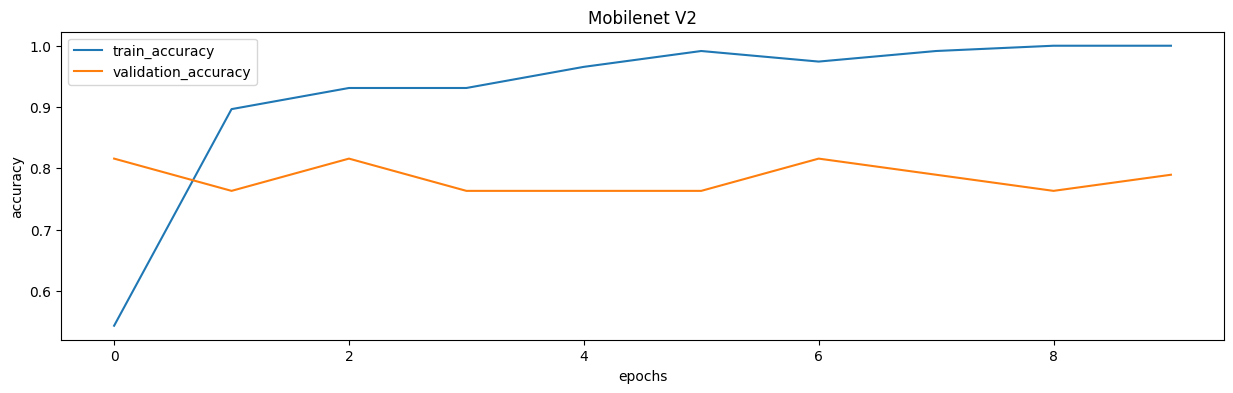

In [38]:
vizualize(history_1, 'Mobilenet V2')

In [39]:
history_2 = train(train_dataloader, valid_dataloader, model=dnet, epochs=10, rate=lr, criterion=crit)

epoch:  10%|█         | 1/10 [00:56<08:24, 56.10s/it]


Epoch 001 train_loss: 0.9970     val_loss 1.1015 train_acc 0.5345 val_acc 0.4737


epoch:  20%|██        | 2/10 [01:58<07:59, 59.93s/it]


Epoch 002 train_loss: 0.5021     val_loss 1.0211 train_acc 0.8879 val_acc 0.6842


epoch:  30%|███       | 3/10 [02:52<06:38, 56.90s/it]


Epoch 003 train_loss: 0.2519     val_loss 0.8193 train_acc 0.9052 val_acc 0.7368


epoch:  40%|████      | 4/10 [03:45<05:32, 55.39s/it]


Epoch 004 train_loss: 0.1326     val_loss 1.0757 train_acc 0.9569 val_acc 0.8421


epoch:  50%|█████     | 5/10 [04:37<04:32, 54.45s/it]


Epoch 005 train_loss: 0.1641     val_loss 1.4719 train_acc 0.9397 val_acc 0.7895


epoch:  60%|██████    | 6/10 [05:30<03:35, 53.99s/it]


Epoch 006 train_loss: 0.1365     val_loss 1.1858 train_acc 0.9741 val_acc 0.7895


epoch:  70%|███████   | 7/10 [06:24<02:41, 53.81s/it]


Epoch 007 train_loss: 0.0685     val_loss 1.0646 train_acc 0.9741 val_acc 0.7895


epoch:  80%|████████  | 8/10 [07:17<01:47, 53.71s/it]


Epoch 008 train_loss: 0.1325     val_loss 0.9637 train_acc 0.9914 val_acc 0.8158


epoch:  90%|█████████ | 9/10 [08:10<00:53, 53.30s/it]


Epoch 009 train_loss: 0.0391     val_loss 0.8866 train_acc 1.0000 val_acc 0.8421


epoch: 100%|██████████| 10/10 [09:03<00:00, 54.34s/it]


Epoch 010 train_loss: 0.1140     val_loss 0.8827 train_acc 0.9655 val_acc 0.8421


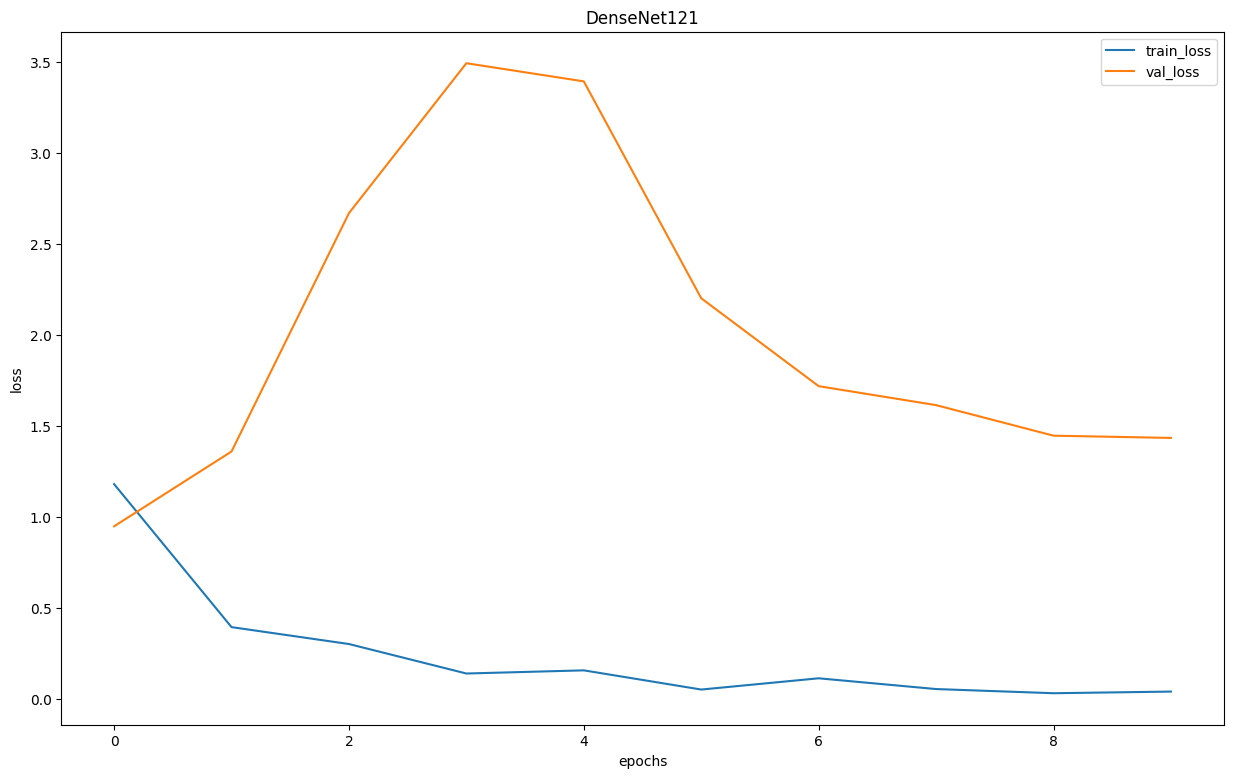

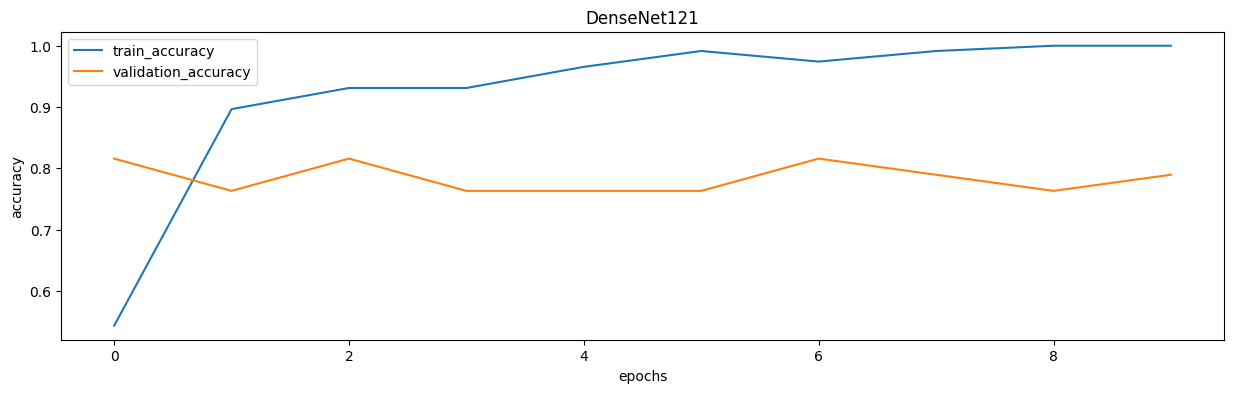

In [40]:
vizualize(history_2, 'DenseNet121')

In [41]:
history_3 = train(train_dataloader, valid_dataloader, model=vgg, epochs=10, rate=lr, criterion=crit)

epoch:  10%|█         | 1/10 [01:15<11:16, 75.17s/it]


Epoch 001 train_loss: 1.3712     val_loss 1.1240 train_acc 0.3276 val_acc 0.4737


epoch:  20%|██        | 2/10 [02:30<10:01, 75.20s/it]


Epoch 002 train_loss: 1.0305     val_loss 0.9978 train_acc 0.5603 val_acc 0.6579


epoch:  30%|███       | 3/10 [03:45<08:47, 75.36s/it]


Epoch 003 train_loss: 0.8551     val_loss 0.9255 train_acc 0.6293 val_acc 0.6316


epoch:  40%|████      | 4/10 [05:00<07:31, 75.21s/it]


Epoch 004 train_loss: 0.7541     val_loss 0.9024 train_acc 0.7586 val_acc 0.7632


epoch:  50%|█████     | 5/10 [06:15<06:15, 75.05s/it]


Epoch 005 train_loss: 0.7062     val_loss 0.8758 train_acc 0.7672 val_acc 0.7632


epoch:  60%|██████    | 6/10 [07:30<05:00, 75.10s/it]


Epoch 006 train_loss: 0.6715     val_loss 0.8699 train_acc 0.8017 val_acc 0.7632


epoch:  70%|███████   | 7/10 [08:45<03:45, 75.03s/it]


Epoch 007 train_loss: 0.6810     val_loss 0.8656 train_acc 0.8190 val_acc 0.7632


epoch:  80%|████████  | 8/10 [10:01<02:30, 75.25s/it]


Epoch 008 train_loss: 0.6740     val_loss 0.8598 train_acc 0.8103 val_acc 0.7632


epoch:  90%|█████████ | 9/10 [11:16<01:15, 75.26s/it]


Epoch 009 train_loss: 0.6676     val_loss 0.8599 train_acc 0.8017 val_acc 0.7632


epoch: 100%|██████████| 10/10 [12:33<00:00, 75.38s/it]


Epoch 010 train_loss: 0.6842     val_loss 0.8598 train_acc 0.8017 val_acc 0.7632


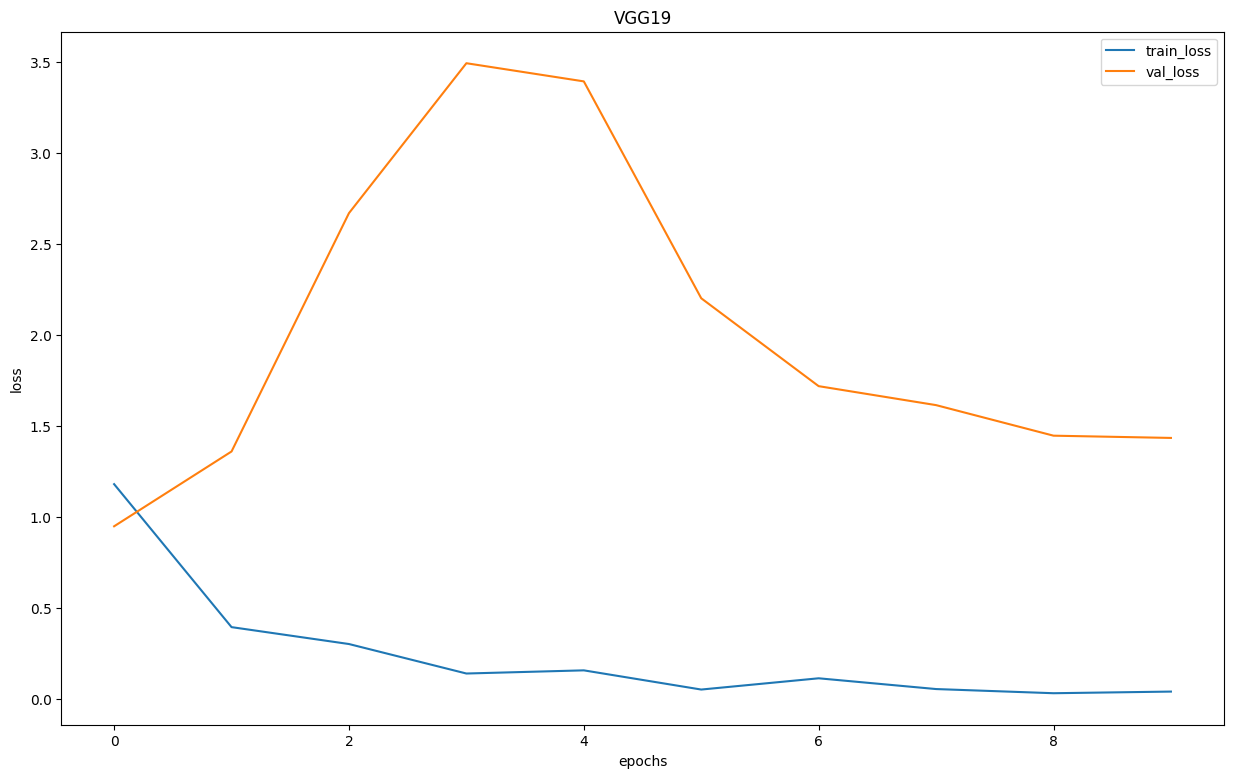

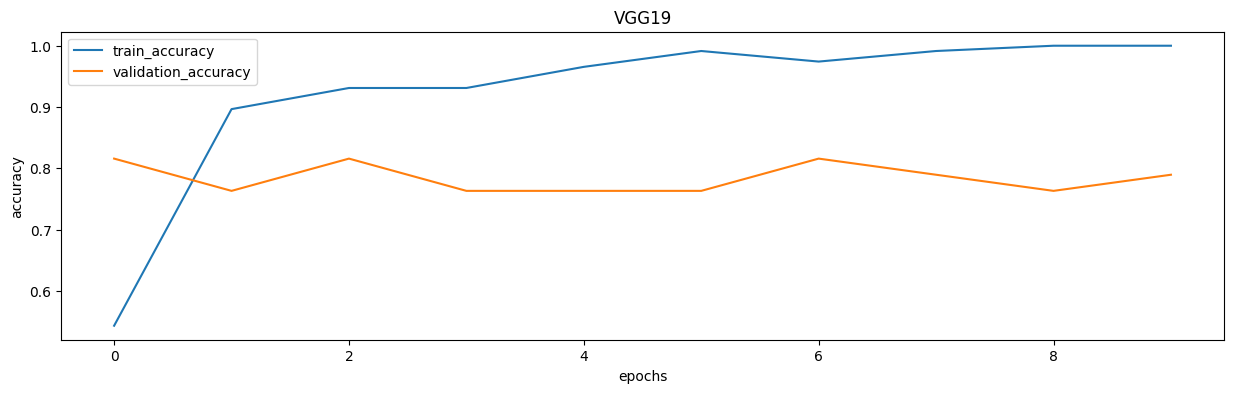

In [42]:
vizualize(history_3, 'VGG19')

#### Тестирование

In [43]:
result_1 = predict(resnet, test_dataloader)
result_2 = predict(mobilenet, test_dataloader)
result_3 = predict(dnet, test_dataloader)
result_4 = predict(vgg, test_dataloader)

In [44]:
print(f'Accuracy на тестовой выборке Resnet50 - {result_1[3]:.2}')
print(f'Accuracy на тестовой выборке Mobilenet V2 - {result_2[3]:.2}')
print(f'Accuracy на тестовой выборке DenseNet121 - {result_3[3]:.2}')
print(f'Accuracy на тестовой выборке VGG19 - {result_4[3]:.2}')

Accuracy на тестовой выборке Resnet50 - 0.92
Accuracy на тестовой выборке Mobilenet V2 - 0.95
Accuracy на тестовой выборке DenseNet121 - 0.95
Accuracy на тестовой выборке VGG19 - 0.74


Две модели показали accuracy на тестовой выборке - 0.95, быстрее была Mobilenet V2, она будет лучшей.

In [45]:
result = result_2

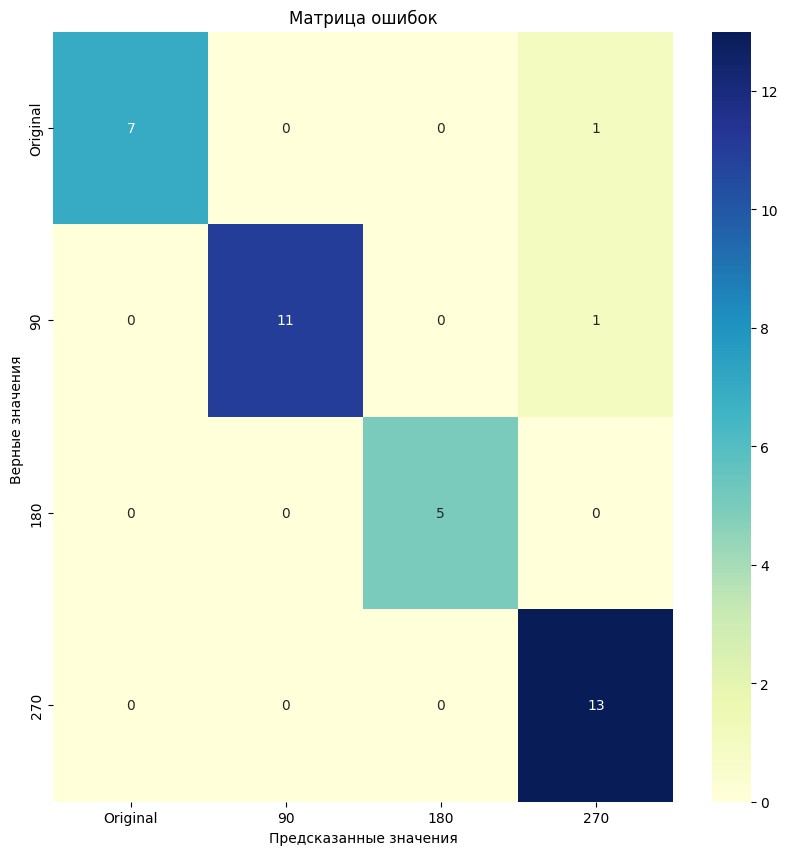

In [46]:
conf_mx = pd.DataFrame(confusion_matrix(result[1], result[0]))

fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(conf_mx, annot= True , fmt="d",  cmap='YlGnBu', ax=ax)

ax.set_title('Матрица ошибок');
ax.set_xlabel('Предсказанные значения')
ax.set_ylabel('Верные значения ');

ax.xaxis.set_ticklabels(['Original','90', '180', '270'])
ax.yaxis.set_ticklabels(['Original','90', '180', '270'])
plt.show()  

#### Предсказанные значения

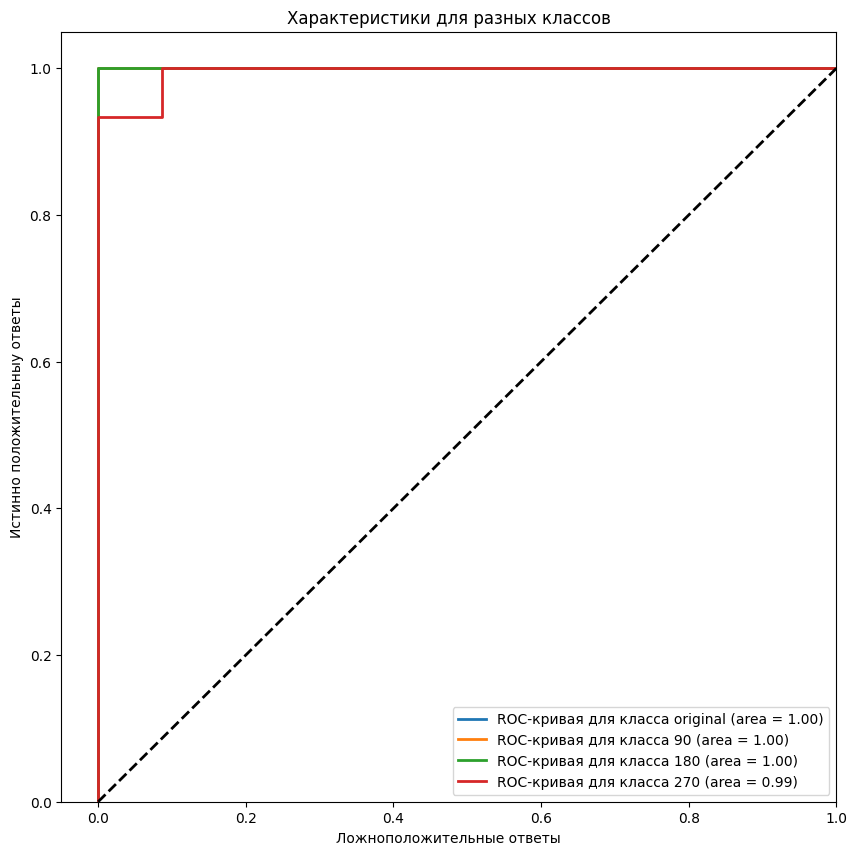

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = list(CLASSES.values())
labels = list(CLASSES.keys())
label_test = label_binarize(result[0], classes=classes)
n_classes = label_test.shape[1]
y_score = result[2]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC-кривая для класса {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Ложноположительные ответы')
plt.ylabel('Истинно положительныу ответы')
plt.title('Характеристики для разных классов')
plt.legend(loc="lower right")
plt.show()

#### Сохранение лучшей модели

In [48]:
!mkdir /kaggle/working/result

mkdir: cannot create directory '/kaggle/working/result': File exists


In [49]:
torch.save(mobilenet.state_dict(), OUT_DIR + 'mobilenet_v2.pth')

### Вывод

В датасете всего 173 изображения, не все из них справки установленной формы №405, которую донор получает в центре крови. 
Отобрали нужные нам справки и повернули каждое изображение  на 90, 180 и 270 градусов увеличив датасет.

Использовали 4 предобученные модели: ResNet50, Mobilenet V2, DenseNet121 и VGG19.
Коэффициент скорости обучения 0.001, на 10 эпохах.

Accuracy на тестовой выборке Resnet50 - 0.92 \
Accuracy на тестовой выборке Mobilenet V2 - 0.95 \
Accuracy на тестовой выборке DenseNet121 - 0.95 \
Accuracy на тестовой выборке VGG19 - 0.74


Две модели показали accuracy на тестовой выборке - 0.95, быстрее была Mobilenet V2, она будет лучшей.